# Traffic Sign Recognition Classifier
Self-Driving Car Engineer Nanodegree

Deep Learning

<a href="https://colab.research.google.com/github/hurtadosanti/TrafficSignClassifier/blob/master/TrafficSignClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Problem Definition](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb)

## Import packages

In [36]:
from google.colab import drive
drive.mount('/content/drive')
path = './drive/"My Drive"/TrafficSignRecognitionClassifier'

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!cp * ./drive/'My Drive'/TrafficSignRecognitionClassifier

cp: -r not specified; omitting directory 'drive'
cp: -r not specified; omitting directory 'sample_data'


In [2]:
!cp ./drive/'My Drive'/TrafficSignRecognitionClassifier/*.jpg .

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle
import os
from zipfile import ZipFile
from sklearn.utils import shuffle
from skimage import data, color
from skimage.transform import rotate, rescale, resize
from skimage.util import random_noise
from PIL import Image
# used in colab to switch to tensorflow 1
#%tensorflow_version 1.x


import tensorflow as tf
from tensorflow.contrib.layers import flatten
print(tf.__version__)

%matplotlib inline


1.14.0


## Load Data

In [12]:
path = '/tmp/'
traffic_signs_file = 'traffic-signs-data.zip'
!wget --no-check-certificate --progress=bar:force:noscroll \
    https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip \
    -O /tmp/traffic-signs-data.zip

!wget --no-check-certificate --progress=bar:force:noscroll \
    https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv -O signnames.csv

with ZipFile(path+traffic_signs_file, 'r') as zipObj:
   zipObj.extractall(path)
   print('Finish extracting')

--2020-09-26 07:55:34--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.9
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘/tmp/traffic-signs-data.zip’

/tmp/traffic-signs- 100%[===================>] 117,80M  8,43MB/s    in 29s     

2020-09-26 07:56:05 (4,00 MB/s) - ‘/tmp/traffic-signs-data.zip’ saved [123524425/123524425]

--2020-09-26 07:56:05--  https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signname

In [14]:
train = pickle.load(open(path+"train.p", 'rb'))
valid=pickle.load(open(path+"valid.p", 'rb'))
test = pickle.load(open(path+"test.p", 'rb'))
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# Verify that the data is complete
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))

assert(len(X_train)>0)
assert(len(X_valid)>0)
assert(len(X_test)>0)
print('Data is correct')

Data is correct


## Data Summary and exploration

In [15]:
# Data Size
print('Training set samples:\t',len(X_train))
print('Validation set samples:\t',len(X_valid))
print('Test set samples:\t',len(X_test))
# Sign names labels
sign_names = pd.read_csv('signnames.csv')
print('\nMetrics\n-------------')
print(sign_names.describe())
print('\nSamples\n-------------')
print(sign_names.head())

Training set samples:	 34799
Validation set samples:	 4410
Test set samples:	 12630

Metrics
-------------
         ClassId
count  43.000000
mean   21.000000
std    12.556539
min     0.000000
25%    10.500000
50%    21.000000
75%    31.500000
max    42.000000

Samples
-------------
   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


### Random Samples

In [16]:
# Random signs from the Y data
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
print('Sample\tSign id\tName\n-----------')
for i in results[:10]:
    sign_index = y_train[i]
    print(f'{i}\t{sign_index}\t{sign_names.at[sign_index,"SignName"]}')

Sample	Sign id	Name
-----------
204	41	End of no passing
6056	3	Speed limit (60km/h)
872	31	Wild animals crossing
8579	4	Speed limit (70km/h)
3452	1	Speed limit (30km/h)
3725	1	Speed limit (30km/h)
2300	1	Speed limit (30km/h)
4538	22	Bumpy road
5804	3	Speed limit (60km/h)
3130	1	Speed limit (30km/h)


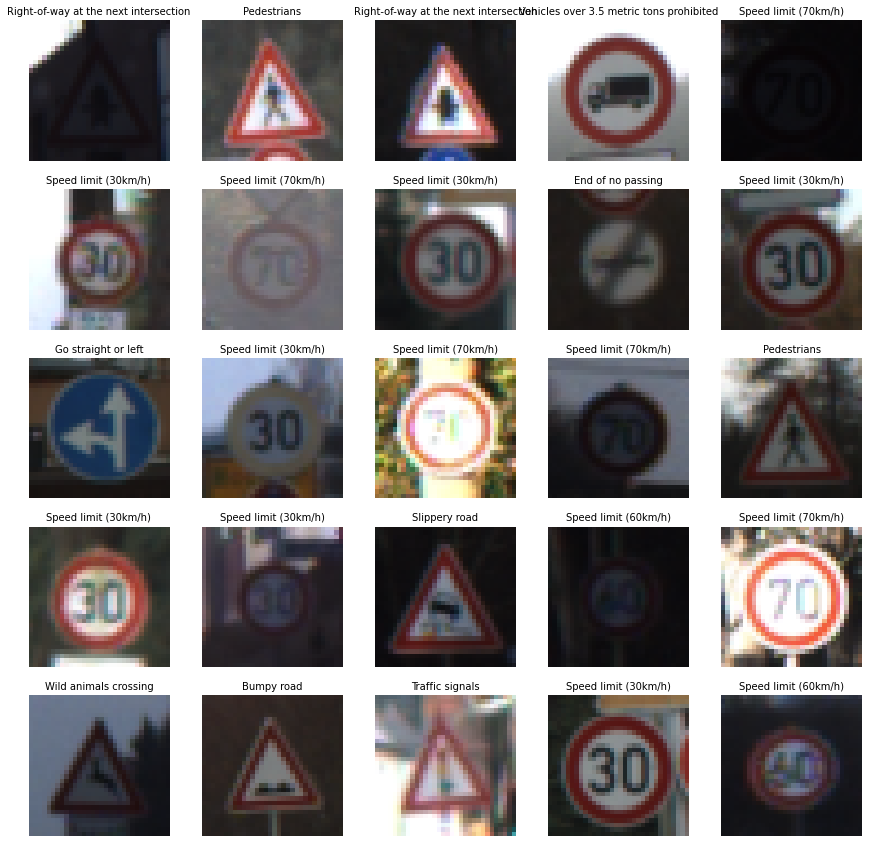

In [ ]:
# Random signs images and the correspondent name
fig, axes = plt.subplots(5,5, figsize=(15,15))
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i,ax in  enumerate(axes.flat):
    pos = results[i]
    sign_index = y_train[pos]
    ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(X_train[pos])
    ax.set_axis_off()

## Data distribution

                  0
count  12630.000000
mean      15.551069
std       11.947123
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000


<AxesSubplot:ylabel='Frequency'>

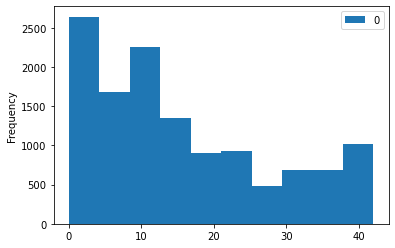

In [17]:
# Describe test Y data
df_y_test = pd.DataFrame(y_test)
print(df_y_test.describe())
df_y_test.plot.hist()

## Data preprocessing

In [18]:
def convert_gray(images):
    gray = []
    for i,img in enumerate(images):
        gray_image = color.rgb2grey(img)
        new_row = np.reshape(gray_image,gray_image.shape+(1,))
        gray.append(new_row)
    result = np.array(gray)
    del gray
    return result

def augment_data_set(images,labels,angle):
    augmented_list = []
    label_list = []
    for i,img in enumerate(images):
      augmented_list.append(rotate(img,angle))
      augmented_list.append(rotate(img,angle*-1))
      augmented_list.append(random_noise(img))
      label_list.append(labels[i])
      label_list.append(labels[i])
      label_list.append(labels[i])
    res_rotated = np.array(augmented_list)
    res_label = np.array(label_list)
    del augmented_list
    del label_list
    return res_rotated,res_label

In [19]:
X_train_normalized = X_train/255.0
X_valid_normalized = X_valid/255.0
#X_train_gray = np.sum(X_train_normalized/3, axis=3, keepdims=True)
X_train_gray = convert_gray(X_train_normalized)
X_valid_gray = convert_gray(X_valid_normalized)
#X_valid_gray = np.sum(X_valid_normalized/3, axis=3, keepdims=True)

### Augment data

In [20]:
augmented_images,augmented_labels = augment_data_set(X_train_gray,y_train,15)
print('augmented data',augmented_images.shape,augmented_labels.shape)
assert len(augmented_images)==len(augmented_labels)
X_train_augmented = np.concatenate((X_train_gray,augmented_images),axis=0)
y_train_augmented = np.concatenate((y_train,augmented_labels),axis=0)

print('complete data',X_train_augmented.shape,y_train_augmented.shape)
assert len(X_train_augmented)==len(y_train_augmented)

augmented data (104397, 32, 32, 1) (104397,)
complete data (139196, 32, 32, 1) (139196,)


In [21]:
# Shuffle to get better results
X_train_shuffle, y_train_shuffle  = shuffle(X_train_augmented, y_train_augmented)

## Training
### Network Architecture

In [22]:
def LeNet(x,dropout):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    # Convolution 1 and max_pool
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #print(conv1.shape)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    # Convolution 2 and max_pool
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #print(conv2.shape)
    # Flatten last convolution
    fc0   = flatten(conv2)
    fc0   = tf.nn.dropout(fc0, dropout)
    #print(fc0.shape)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    #print(fc1.shape,fc2_W.shape,fc2_b.shape)
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

### Prepare the model

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)
rate = 0.0005
dropout = 0.4
logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Execute the training
We stop when accuracy is over 0.95

In [24]:
BATCH_SIZE=128
EPOCHS=15

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def evaluate(X_data, y_data):
    examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for eval_offset in range(0, examples, BATCH_SIZE):
        eval_batch_x, eval_batch_y = X_data[eval_offset:eval_offset+BATCH_SIZE], y_data[eval_offset:eval_offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: eval_batch_x,
                                                           y: eval_batch_y,
                                                           keep_prob: 1.})
        total_accuracy += (accuracy * len(eval_batch_x))
    return total_accuracy / examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_shuffle)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffle, y_train_shuffle = shuffle(X_train_shuffle, y_train_shuffle)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffle[offset:end], y_train_shuffle[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: dropout})

        validation_accuracy = evaluate(X_valid_gray, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if validation_accuracy >= 0.95:
            print(f'We made it with :{validation_accuracy}')
            saver.save(sess, './lenet')
            print("Model saved")
            break
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.861

EPOCH 2 ...
Validation Accuracy = 0.900

EPOCH 3 ...
Validation Accuracy = 0.917

EPOCH 4 ...
Validation Accuracy = 0.934

EPOCH 5 ...
Validation Accuracy = 0.940

EPOCH 6 ...
Validation Accuracy = 0.945

EPOCH 7 ...
Validation Accuracy = 0.953

We made it with :0.9526077097505669
Model saved


## Test the model

In [25]:
X_test_normalized = X_test/255.0
#X_train_gray = np.sum(X_train_normalized/3, axis=3, keepdims=True)
X_test_gray = convert_gray(X_test_normalized)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.935


# Custom Images

## Read images into a numpy array to be tested

In [ ]:
with ZipFile('images.zip', 'r') as zipObj:
   zipObj.extractall('./')
   print('Finish extracting')

Finish extracting


image read:	05-27_Pedestrians.jpg
image read:	04-23_Slippery_road.jpg
image read:	01-40_Roundabout_mandatory.jpg
image read:	03-11_Right-of-way_at_the_next_intersection.jpg
image read:	02-28_Children_crossing.jpg
image read:	06-25_Road_work.jpg


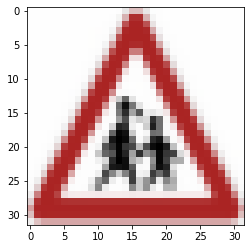

In [26]:
# Get all the jpg images on the folder and rescale
test_images = []
test_labels = []
for f in os.listdir():
  if f.endswith('.jpg'):
    print(f'image read:\t{f}')
    img = Image.open(f)
    img = np.asarray(img)
    test_images.append(resize(img,(32,32)))
    test_labels.append(f[3:5])
test_images = np.asarray(test_images)
test_gray_images = convert_gray(test_images)
plt.imshow(test_images[4])

In [27]:
test_labels = np.asarray(test_labels)
print(test_gray_images.shape,test_labels.shape)

(6, 32, 32, 1) (6,)


## Custom predictions
Predict the Sign Type for Each Image

In [28]:
prediction=tf.argmax(logits,1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: test_gray_images, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./lenet


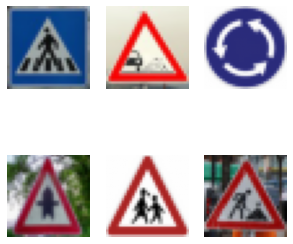

In [38]:
fig, axes = plt.subplots(2,3, figsize=(5,5))
for i,ax in  enumerate(axes.flat):
    sign_index = test_labels[i]
    #ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(test_images[i])
    ax.set_axis_off()

In [29]:
for i,val in enumerate(predictions):
  print(f'{i}\t{sign_names.at[val,"SignName"]}\t{val}\t{test_labels[i]}')

0	General caution	18	27
1	Bumpy road	22	23
2	Roundabout mandatory	40	40
3	Right-of-way at the next intersection	11	11
4	Children crossing	28	28
5	Road work	25	25


## Custom data accuracy

In [39]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(test_gray_images, test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.667


## Softmax Probabilities

In [40]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    session_softmax_logits = sess.run(softmax_logits, feed_dict={x: test_gray_images,
                                                                 keep_prob: 1.0})
    session_top_k = sess.run(top_k, feed_dict={x: test_gray_images, keep_prob: 1.0})
 

INFO:tensorflow:Restoring parameters from ./lenet


## What other options where predicted

In [41]:
for i in session_top_k.indices:
    for j in i[:-3]:
        print(sign_names.at[j,'SignName'],end = '|')
    print()

General caution|Road work|
Bumpy road|Bicycles crossing|
Roundabout mandatory|End of no passing by vehicles over 3.5 metric tons|
Right-of-way at the next intersection|Beware of ice/snow|
Children crossing|Bumpy road|
Road work|Dangerous curve to the right|


## Top 5 predictions
Real Values, Predicted Values

In [42]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
for i,predictions in enumerate(session_top_k.indices):
  print(test_labels[i],predictions)

27 [18 25 26 29 40]
23 [22 29 28 24 30]
40 [40 42 11 12 38]
11 [11 30 27 18 21]
28 [28 22 24 29 11]
25 [25 20 24 30 11]


In [44]:
print(session_softmax_logits)
print('---------')
print(session_top_k)

[[5.04826545e-04 1.63028250e-04 4.23760443e-10 2.31826624e-11
  2.70715864e-05 1.46303293e-07 1.30993683e-07 5.03982234e-09
  2.32847999e-08 1.19735902e-10 7.29927577e-11 1.09772116e-03
  1.81011949e-03 1.00329575e-13 2.71993694e-09 1.73551328e-07
  1.29840849e-09 4.34257057e-12 9.50128675e-01 6.05495476e-09
  3.92053298e-05 4.96302448e-08 1.00019783e-07 2.86390991e-06
  1.07497314e-03 2.07178742e-02 9.65742860e-03 1.70520798e-03
  1.35347409e-05 7.90465251e-03 2.10732615e-05 3.76849721e-06
  9.61152722e-08 9.06976129e-05 2.33218586e-07 4.47794628e-06
  4.05484769e-07 8.10610130e-04 6.71282351e-07 2.14999997e-11
  4.22013272e-03 3.54618779e-09 4.44395631e-09]
 [7.44363234e-26 4.07569262e-27 1.88173455e-28 4.08025053e-27
  3.79925615e-33 5.78113748e-27 2.93047046e-38 2.61031697e-29
  1.57456372e-22 6.90829663e-21 1.38929349e-29 1.50871899e-15
  5.03049859e-22 3.13331649e-30 3.77430665e-34 3.48957308e-18
  6.09538207e-38 7.12665815e-38 5.56074182e-14 9.06041498e-15
  3.88465722e-08 1.098